# Model Training

Model comparison (XGBoost, RandomForest, Ridge, etc.) with RMSE evaluation. 

To be added from national-news.ipynb soon!

In [1]:
# Load features from 04-feature-engineering.ipynb
import pandas as pd
df_lda = pd.read_csv("../data/processed/features_lda_monthly.csv")

In [2]:
# print preview of the features dataFrame
cols = ['month', 'INDPRO', 'sentiment'] + [c for c in df_lda.columns if c not in ('month', 'INDPRO', 'sentiment')]
display(df_lda[cols].head())

,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False


In [4]:
df = df_lda.copy()

## Compare different models

### 1. Define models and their hyperparameter grids

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

models_and_params = {
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    }
}


### 2. Time-aware train/test split

In [5]:
# Define features and target
features = [col for col in df.columns if col.startswith('topic_') or col.startswith('publication_')]
features.append('sentiment')
X = df[features]
y = df['INDPRO']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Set Up TimeSeriesSplit ---
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

### 3. Run GridSearchCV with 3-fold CV

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

best_models = []
for name, mp in models_and_params.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=0
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    best_models.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Test RMSE': rmse
    })




🔍 Tuning XGBoost...

🔍 Tuning RandomForest...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...


### 4. Display results

In [7]:
results_df = pd.DataFrame(best_models).sort_values(by='Test RMSE')
print(results_df)



              Model                                        Best Params  \
1      RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
0           XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
2  GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
3             Ridge                                     {'alpha': 0.1}   

   Test RMSE  
1   2.961406  
0   3.065962  
2   3.145013  
3   3.228735  


### 5. Visualization

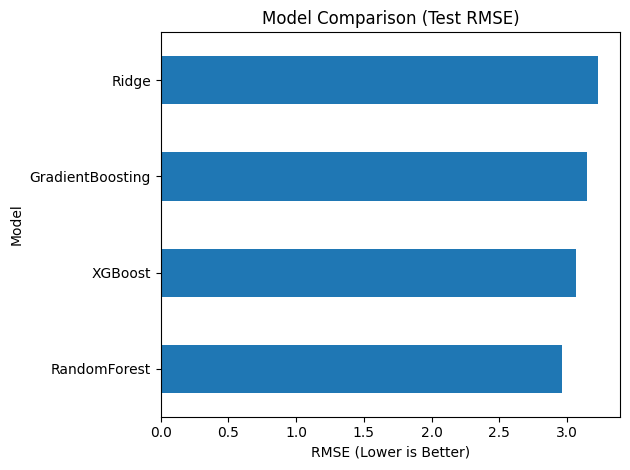

In [8]:
import matplotlib.pyplot as plt

results_df.plot(x='Model', y='Test RMSE', kind='barh', legend=False, title='Model Comparison (Test RMSE)')
plt.xlabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.show()

### 6. Save Best Models

In [9]:
# Save best models
import joblib
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# 1) Identify best model by lowest RMSE
best_idx     = results_df['Test RMSE'].idxmin()
best_name    = results_df.loc[best_idx, 'Model']
best_params  = results_df.loc[best_idx, 'Best Params']

# 2) Re‐instantiate and fit on full training set
if best_name == 'XGBoost':
    best_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
elif best_name == 'RandomForest':
    best_model = RandomForestRegressor(random_state=42, **best_params)
elif best_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(random_state=42, **best_params)
elif best_name == 'Ridge':
    best_model = Ridge(**best_params)
else:
    raise ValueError(f"Unknown model: {best_name}")

best_model.fit(X_train, y_train)

# 3) Save to disk for later use (e.g. SHAP analysis)
model_path = "../models/best_model.joblib"
joblib.dump(best_model, model_path)
print(f"✅ Saved best model ({best_name}) to {model_path}")


✅ Saved best model (RandomForest) to ../models/best_model.joblib
